In [1]:
import os
os.chdir("..")
os.chdir("..")
from Plots.Other_plots import Other_Plots
from requirements import *
plots = Other_Plots()

## Multivariate Outliers Detection comparison

$\text{Firstly, I will compare the performance of the following algorithms:}$<p>
$\text{1. Mahalanobis distance}$<p>
$\text{2. Isolation Forest}$<p>
$\text{3. Local Outlier Factor}$<p>
$\text{To do this, I will use simple dataset with 2 features to visualize the results.}$

In [2]:
from sklearn.datasets import make_blobs
X = make_blobs(n_samples=1000, n_features=2, cluster_std=0.5, random_state=17, centers=[[0, 0], [0, 0]])[0]

## Mahalanobis distance

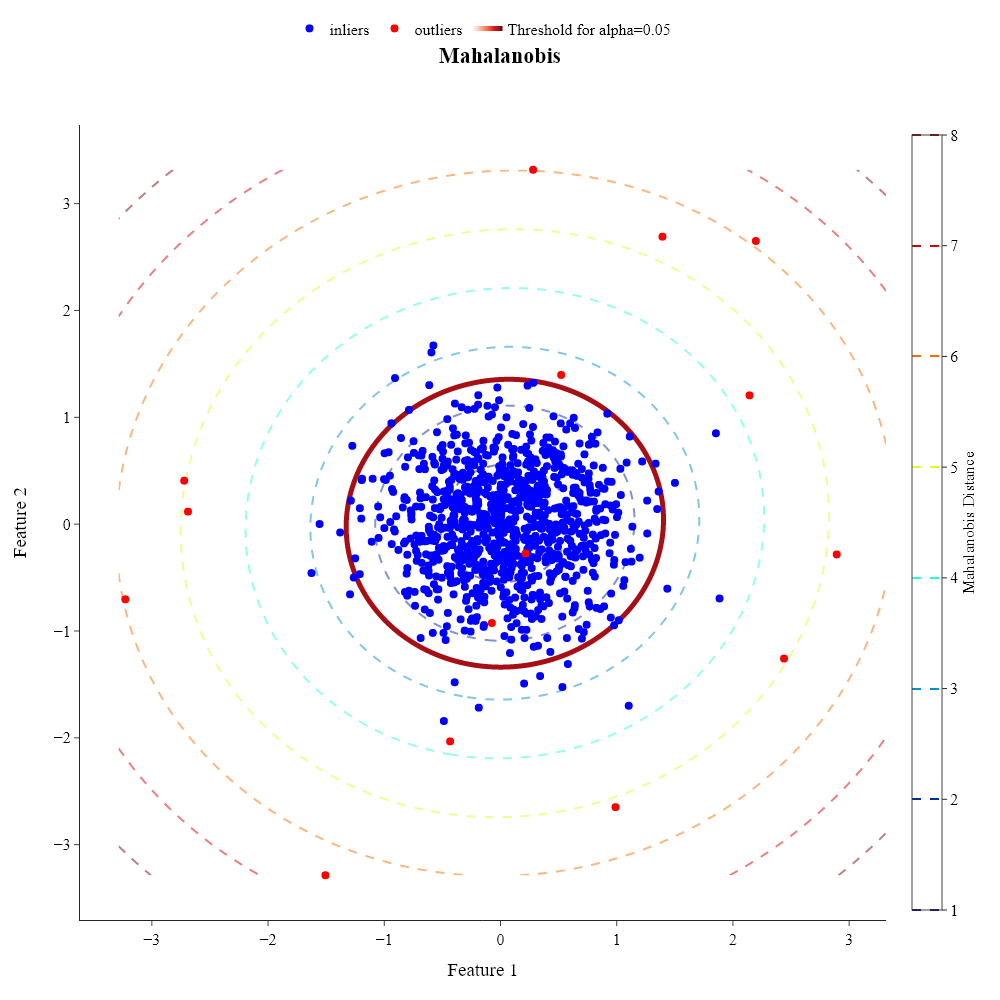

In [3]:
plots.mahalanobis_plot(X=X, n_outliers=15, alpha=0.05)

$\text{As we can see using Mahalanobis distance, we can detect the outliers in the dataset.}$<p>
$\text{We can also use other threshold values to define better line to separate the outliers from the inliers.}$

$\text{Below we can plot the Mahalanobis distance for the dataset.}$

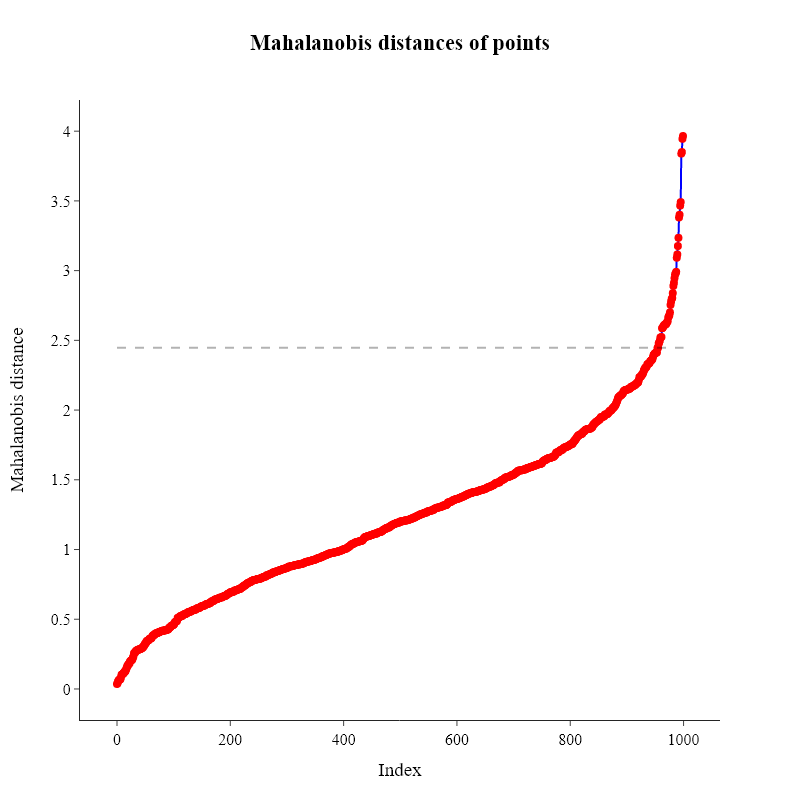

In [4]:
plots.mahalanobis_distance_plot(X=X, alpha=0.05)

## Isolation Forest

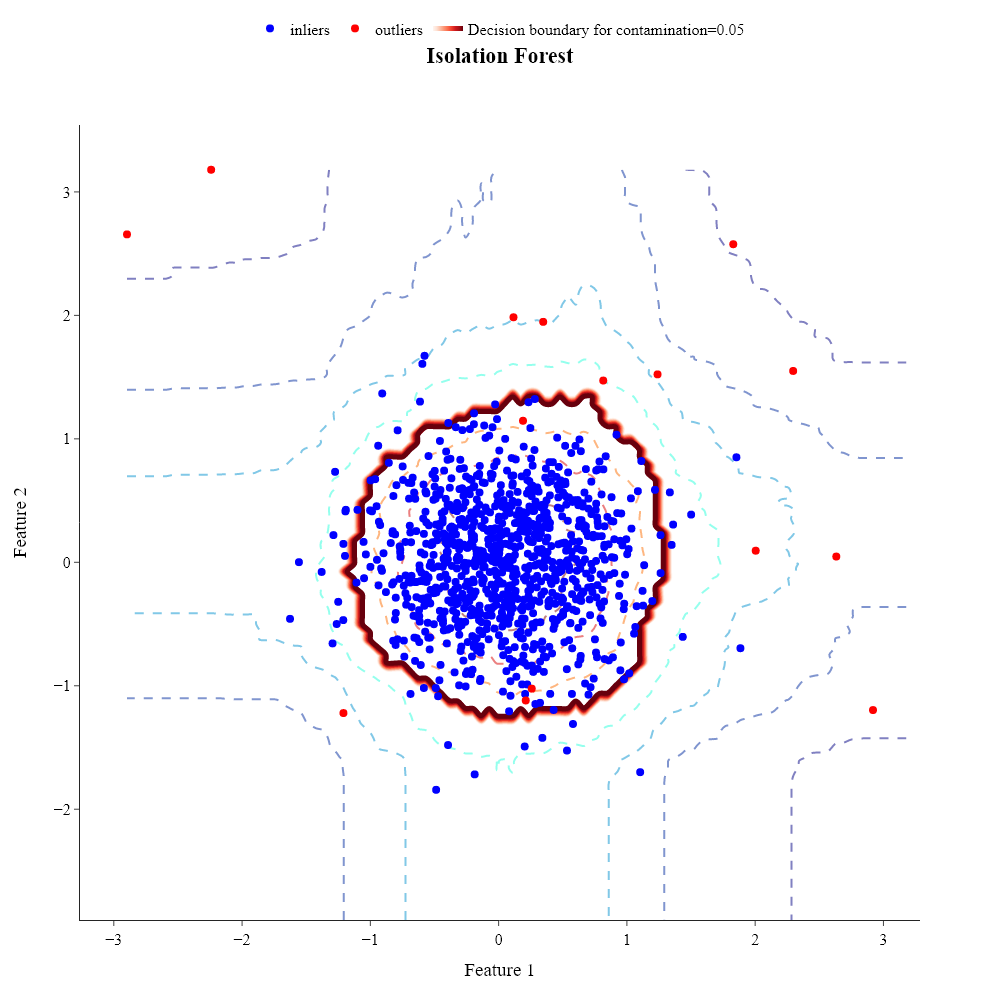

In [5]:
plots.isolation_forest_plot(X=X, n_outliers=15, contamination=0.05)

$\text{Decision boundary is pretty simmilar to the Mahalanobis distance threshold.}$<p>
$\text{We can also use other contamination values to define better line to separate the outliers from the inliers.}$

## Local Outlier Factor

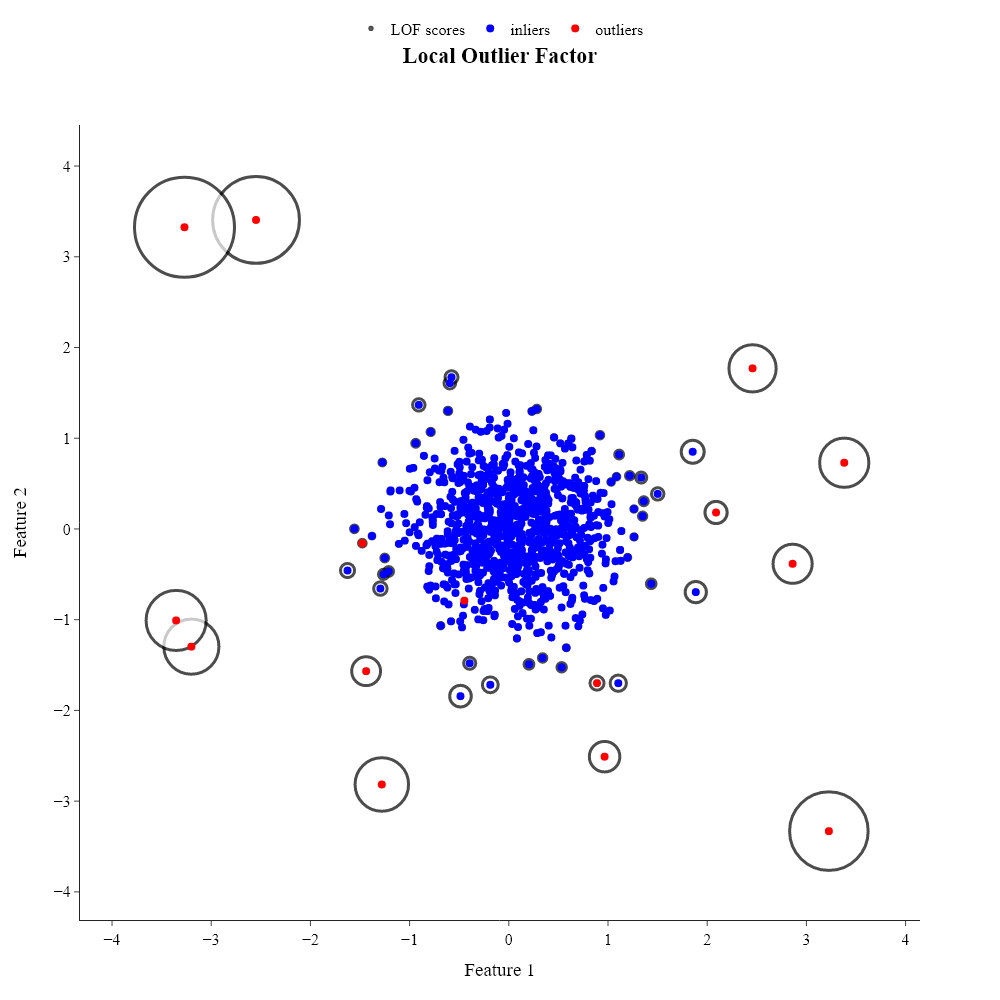

In [6]:
plots.local_outlier_factor_plot(X=X, n_outliers=15, contamination=0.05)

$\text{Local Outlier Factor is also able to detect the outliers in the dataset.}$<p>
$\text{Boundaries which are plotted as circles are the areas where the algorithm is more likely to define the point as an outlier.}$<p>
$\text{Simmilarly to above algorithms, we can also use other contamination values to define better line to separate the outliers from the inliers.}$

# Optimization

$\text{We will use insurance dataset to compare the performance of the algorithms.}$<p>
$\text{We will use optuna for hyperparameter optimization.}$<p>
$\text{AUC score will be used as the metric for optimization.}$

In [7]:
data = pd.read_csv("Data_Cleaning/Data/insurance.csv")
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=17)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

$\text{Before we start we will quickly convert object columns to numerical using OneHotEncoder.}$

In [9]:
one_hot = ["sex", "region"]
for feature in one_hot:
    unique_values = np.sort(train_data[feature].unique())
    unknown_test_indices = test_data.loc[~test_data[feature].isin(unique_values)].index.tolist()
    one_hot_encoder = OneHotEncoder(drop="first", categories=[unique_values], handle_unknown='ignore', sparse_output=False)
    encoded_cols_drop_first = [f"{feature}_{val}" for val in np.delete(unique_values, 0)]
    one_hot_encoder.fit(train_data[feature].values.reshape(-1, 1))
    train_transformed = one_hot_encoder.transform(train_data[feature].values.reshape(-1, 1))
    test_transformed = one_hot_encoder.transform(test_data[feature].values.reshape(-1, 1))
    train_transformed = pd.DataFrame(train_transformed, columns=encoded_cols_drop_first)
    test_transformed = pd.DataFrame(test_transformed, columns=encoded_cols_drop_first)
    test_transformed.loc[unknown_test_indices, :] = -1
    train_data = pd.concat([train_data, train_transformed], axis=1).drop(feature, axis=1)
    test_data = pd.concat([test_data, test_transformed], axis=1).drop(feature, axis=1)

In [10]:
X_train = train_data.drop("smoker", axis=1)
y_train = train_data["smoker"]
X_test = test_data.drop("smoker", axis=1)
y_test = test_data["smoker"]

## Base scores

In [11]:
lgbm_param = {
        "objective": "binary",
        "metric": "logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 17,
        "n_jobs": 5
    }
lgbm_classifier = LGBMClassifier(**lgbm_param)
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

Accuracy: 0.9701492537313433
ROC AUC: 0.9917773561037319


## Mahalanobis distance

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
def objective(trial, X, y):
    mahalanobis_param = {
        "alpha": trial.suggest_float("alpha", 0.001, 0.2),
    }
    lgbm_classifier = LGBMClassifier(**lgbm_param)
    scores = []
    for iter, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_cv, X_valid_cv = X.iloc[train_idx, :], X.iloc[valid_idx, :]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]
        empirical_cov = EmpiricalCovariance().fit(X_train_cv)
        mahal_emp_cov = empirical_cov.mahalanobis(X_train_cv)**0.5
        mahal_emp_cov = np.sort(mahal_emp_cov)
        threshold = np.sqrt(chi2.ppf(1-mahalanobis_param["alpha"], df=X_train_cv.shape[1]))
        X_train_no_outliers = X_train_cv[mahal_emp_cov < threshold]
        y_train_no_outliers = y_train_cv[mahal_emp_cov < threshold]
        lgbm_classifier.fit(X_train_no_outliers, y_train_no_outliers)
        y_pred_proba = lgbm_classifier.predict_proba(X_valid_cv)[:, 1]
        scores.append(roc_auc_score(y_valid_cv, y_pred_proba))
    return np.mean(scores)
sampler = optuna.samplers.TPESampler(seed=17)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)
best_params = study.best_params
best_alpha = best_params["alpha"]

[I 2024-02-18 19:52:57,607] A new study created in memory with name: no-name-981e18e7-e4bd-4adc-ba51-6c74ea4a3c9f
[I 2024-02-18 19:52:57,716] Trial 0 finished with value: 0.992844912754415 and parameters: {'alpha': 0.05963833553473483}. Best is trial 0 with value: 0.992844912754415.
[I 2024-02-18 19:52:57,818] Trial 1 finished with value: 0.9928975097300888 and parameters: {'alpha': 0.10658676436545353}. Best is trial 1 with value: 0.9928975097300888.
[I 2024-02-18 19:52:57,914] Trial 2 finished with value: 0.9931626920088459 and parameters: {'alpha': 0.03911263660255148}. Best is trial 2 with value: 0.9931626920088459.
[I 2024-02-18 19:52:58,020] Trial 3 finished with value: 0.9924144683873191 and parameters: {'alpha': 0.01451217128006698}. Best is trial 2 with value: 0.9931626920088459.
[I 2024-02-18 19:52:58,117] Trial 4 finished with value: 0.9926371617321845 and parameters: {'alpha': 0.15761010653998275}. Best is trial 2 with value: 0.9931626920088459.
[I 2024-02-18 19:52:58,216] 

In [13]:
empirical_cov = EmpiricalCovariance().fit(X_train)
mahal_emp_cov = empirical_cov.mahalanobis(X_train)**0.5
mahal_emp_cov = np.sort(mahal_emp_cov)
threshold = np.sqrt(chi2.ppf(1-best_alpha, df=X_train.shape[1]))
X_train_no_outliers = X_train[mahal_emp_cov <= threshold]
y_train_no_outliers = y_train[mahal_emp_cov <= threshold]
mahal_indices_of_outliers = X_train.index[mahal_emp_cov > threshold].tolist()
print(f"Number of outliers: {X_train.shape[0] - X_train_no_outliers.shape[0]}")
print("Ratio of outliers:", (X_train.shape[0] - X_train_no_outliers.shape[0]) / X_train.shape[0])
lgbm_classifier = LGBMClassifier(**lgbm_param)
lgbm_classifier.fit(X_train_no_outliers, y_train_no_outliers)
y_pred = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

Number of outliers: 32
Ratio of outliers: 0.029906542056074768
Accuracy: 0.9664179104477612
ROC AUC: 0.9909641275865184


$\text{As we can see after removing outliers from training set based on Mahalanobis distance, accuracy and AUC scores decreased.}$

## Isolation Forest

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
def objective(trial, X, y):
    isolation_forest_param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "contamination": trial.suggest_float("contamination", 0.005, 0.05),
        "max_samples": trial.suggest_float("max_samples", 0.2, 0.4),
        "bootstrap": True,
        "n_jobs": 3,
        "random_state": 17,
        "verbose": 0
    }
    lgbm_classifier = LGBMClassifier(**lgbm_param)
    isolation_forest = IsolationForest(**isolation_forest_param)
    scores = []
    for iter, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_cv, X_valid_cv = X.iloc[train_idx, :], X.iloc[valid_idx, :]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]
        X_train_cv = np.array(X_train_cv)
        isolation_forest.fit(X_train_cv)
        X_train_no_outliers = X_train_cv[isolation_forest.predict(X_train_cv) == 1]
        y_train_no_outliers = y_train_cv[isolation_forest.predict(X_train_cv) == 1]
        lgbm_classifier.fit(X_train_no_outliers, y_train_no_outliers)
        y_pred_proba = lgbm_classifier.predict_proba(X_valid_cv)[:, 1]
        scores.append(roc_auc_score(y_valid_cv, y_pred_proba))
    return np.mean(scores)
sampler = optuna.samplers.TPESampler(seed=17)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)
isolation_forest_best_params = study.best_params

[I 2024-02-18 19:53:08,650] A new study created in memory with name: no-name-9364a19f-964e-4633-879a-c7529abffc0b
[I 2024-02-18 19:53:09,357] Trial 0 finished with value: 0.9932985792488054 and parameters: {'n_estimators': 94, 'contamination': 0.05775280800447648, 'max_samples': 0.23830415738949898}. Best is trial 0 with value: 0.9932985792488054.
[I 2024-02-18 19:53:09,847] Trial 1 finished with value: 0.9929571383870026 and parameters: {'n_estimators': 60, 'contamination': 0.0808286913999922, 'max_samples': 0.33126670435517114}. Best is trial 0 with value: 0.9932985792488054.
[I 2024-02-18 19:53:10,918] Trial 2 finished with value: 0.9920016032233226 and parameters: {'n_estimators': 146, 'contamination': 0.06180426043777307, 'max_samples': 0.2078125832377733}. Best is trial 0 with value: 0.9932985792488054.
[I 2024-02-18 19:53:11,681] Trial 3 finished with value: 0.9926599443794013 and parameters: {'n_estimators': 104, 'contamination': 0.09511148681365669, 'max_samples': 0.2120089360

In [15]:
isolation_forest = IsolationForest(**isolation_forest_best_params)
isolation_forest.fit(X_train)
X_train_no_outliers = X_train[isolation_forest.predict(X_train) == 1]
y_train_no_outliers = y_train[isolation_forest.predict(X_train) == 1]
isolation_forest_indices_of_outliers = X_train.index[isolation_forest.predict(X_train) == -1].tolist()
print("Number of outliers:", X_train.shape[0] - X_train_no_outliers.shape[0])
print("Ratio of outliers:", (X_train.shape[0] - X_train_no_outliers.shape[0]) / X_train.shape[0])
lgbm_classifier = LGBMClassifier(**lgbm_param)
lgbm_classifier.fit(X_train_no_outliers, y_train_no_outliers)
y_pred = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

C:\Users\Kuba\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Number of outliers: 53
Ratio of outliers: 0.04953271028037383
Accuracy: 0.9664179104477612
ROC AUC: 0.9915966386554623


$\text{Isolation Forest also decreased the accuracy and AUC scores after removing the outliers from the training set.}$

## Local Outlier Factor

$\text{Before performing outliers detection using LOF we should scale the data.}$

In [16]:
X_train_lof = X_train.copy()
scaler = StandardScaler()
X_train_lof = scaler.fit_transform(X_train_lof)
X_train_lof = pd.DataFrame(X_train_lof, columns=X_train.columns)

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
def objective(trial, X, y):
    lof_param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 5, 40),
        "contamination": trial.suggest_float("contamination", 0.005, 0.05),
        "n_jobs": 3,
    }
    lgbm_classifier = LGBMClassifier(**lgbm_param)
    lof = LocalOutlierFactor(**lof_param)
    scores = []
    for iter, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train_cv, X_valid_cv = X.iloc[train_idx, :], X.iloc[valid_idx, :]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]
        X_train_no_outliers = X_train_cv[lof.fit_predict(X_train_cv) == 1]
        y_train_no_outliers = y_train_cv[lof.fit_predict(X_train_cv) == 1]
        lgbm_classifier.fit(X_train_no_outliers, y_train_no_outliers)
        y_pred_proba = lgbm_classifier.predict_proba(X_valid_cv)[:, 1]
        scores.append(roc_auc_score(y_valid_cv, y_pred_proba))
    return np.mean(scores)
sampler = optuna.samplers.TPESampler(seed=17)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X_train_lof, y_train), n_trials=100)
lof_best_params = study.best_params

[I 2024-02-18 19:54:55,485] A new study created in memory with name: no-name-deed3b24-c2b9-44a2-848e-c3fd82e7aace
[I 2024-02-18 19:54:55,679] Trial 0 finished with value: 0.9917092434965739 and parameters: {'n_neighbors': 15, 'contamination': 0.11081148356500588}. Best is trial 0 with value: 0.9917092434965739.
[I 2024-02-18 19:54:55,860] Trial 1 finished with value: 0.9925459608265038 and parameters: {'n_neighbors': 11, 'contamination': 0.02290106805634536}. Best is trial 1 with value: 0.9925459608265038.
[I 2024-02-18 19:54:56,051] Trial 2 finished with value: 0.9932333076676969 and parameters: {'n_neighbors': 33, 'contamination': 0.13470336913741254}. Best is trial 2 with value: 0.9932333076676969.
[I 2024-02-18 19:54:56,252] Trial 3 finished with value: 0.9931706026502406 and parameters: {'n_neighbors': 27, 'contamination': 0.11936454981307645}. Best is trial 2 with value: 0.9932333076676969.
[I 2024-02-18 19:54:56,427] Trial 4 finished with value: 0.9911692103773552 and parameters

In [18]:
lof = LocalOutlierFactor(**lof_best_params)
X_train_no_outliers = X_train[lof.fit_predict(X_train_lof) == 1]
y_train_no_outliers = y_train[lof.fit_predict(X_train_lof) == 1]
lof_indices_of_outliers = X_train.index[lof.fit_predict(X_train) == -1].tolist()
print("Number of outliers:", X_train.shape[0] - X_train_no_outliers.shape[0])
print("Ratio of outliers:", (X_train.shape[0] - X_train_no_outliers.shape[0]) / X_train.shape[0])
lgbm_classifier = LGBMClassifier(**lgbm_param)
lgbm_classifier.fit(X_train_no_outliers, y_train_no_outliers)
y_pred = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

Number of outliers: 143
Ratio of outliers: 0.1336448598130841
Accuracy: 0.9626865671641791
ROC AUC: 0.9914159212071925


$\text{Local Outlier Factor also decreased the accuracy and AUC scores after removing the outliers from the training set.}$

## Combination of all algorithms

In [19]:
intersection_of_outliers = list(set(mahal_indices_of_outliers) & set(isolation_forest_indices_of_outliers) & set(lof_indices_of_outliers))
print("Intersection of outliers:", len(intersection_of_outliers))
X_train_no_outliers = X_train.drop(intersection_of_outliers, axis=0)
y_train_no_outliers = y_train.drop(intersection_of_outliers)
lgbm_classifier = LGBMClassifier(**lgbm_param)
lgbm_classifier.fit(X_train_no_outliers, y_train_no_outliers)
y_pred = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")

Intersection of outliers: 1
Accuracy: 0.9664179104477612
ROC AUC: 0.9916869973795971


$\text{Combination of all algorithms have slightly decreased the accuracy and AUC scores after removing the outliers from the training set.}$<p>
$\text{It seems that the algorithms are not able to detect the outliers in the dataset.}$<p>
$\text{What is worth mentioning is that the accuracy and AUC scores are very simmilar for all algorithms.}$<p>
$\text{Also dataset is pretty small, so it might be the reason why the algorithms are not able to detect the good outliers.}$